**GitHub**

In [13]:
# !git clone https://github.com/williamjohn972/Deep-Learning-for-ECG-Heartbeat-Classification.git
# %cd Deep-Learning-for-ECG-Heartbeat-Classification

In [14]:
# !pip install neurokit2 torchmetrics

**Kaggle**

Arrhythmia Dataset
Number of Samples: 109446  
Number of Categories: 5  
Sampling Frequency: 125Hz  
**Classes: ['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4]**   
Data Source: Physionet's MIT-BIH Arrhythmia Dataset  

Remark: All the samples are cropped, downsampled and padded with zeroes if necessary to the fixed dimension of 188.  

In [15]:
# from google.colab import files
# files.upload()   # Upload your kaggle.json here

# !mkdir -p ~/.kaggle
# !mv kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

# !kaggle datasets download -d shayanfazeli/heartbeat

# !unzip heartbeat.zip -d ecg_data

**Lets Begin**

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split

from utils.data import *

In [17]:
mitbih_train_val_df = pd.read_csv("data/mitbih_train.csv", header=None)
mitbih_test_df = pd.read_csv("data/mitbih_test.csv", header=None)
print(f"MitBih (Train + Val) Df shape: {mitbih_train_val_df.shape}")
print(f"MitBih Test Df shape: {mitbih_test_df.shape}")

MitBih (Train + Val) Df shape: (87554, 188)
MitBih Test Df shape: (21892, 188)


In [18]:
class_map = {
    "0": "N", 
    "1": "S",
    "2": "V",
    "3": "F",
    "4": "Q"
}

-- Separate Features (X) and Labels (y)

In [19]:
X, y = split_x_y(mitbih_train_val_df) # (Train + Val)
X_test, y_test = split_x_y(mitbih_test_df) # (Test)

-- Plot Class Distribution

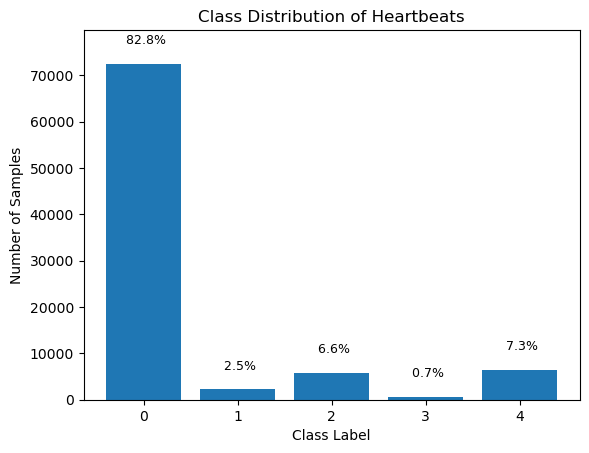

In [20]:
plot_class_distributions(y=y, 
                         title="Class Distribution of Heartbeats",
                         xlabel="Class Label",
                         ylabel="Number of Samples",)

-- Creating our Train Val Split  

We notice that there is a significant imbalance in classes  
Hence we will use a stratified split

In [21]:
X_train, X_val, y_train, y_val = train_test_split(
    X,y,
    test_size= 0.2,
    random_state= 42,
    stratify= y # ensures equal class representation
)

-- Plotting Samples from each Class before Normalisation

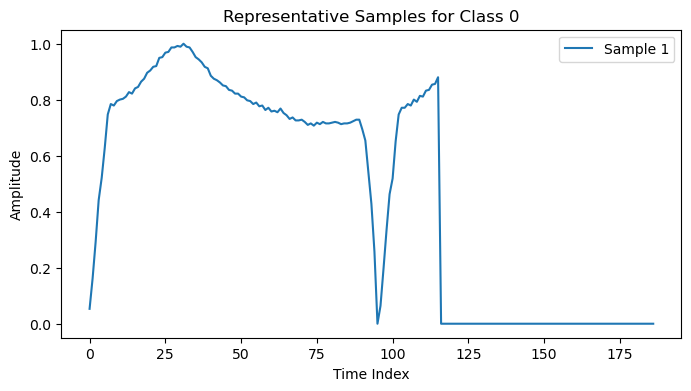

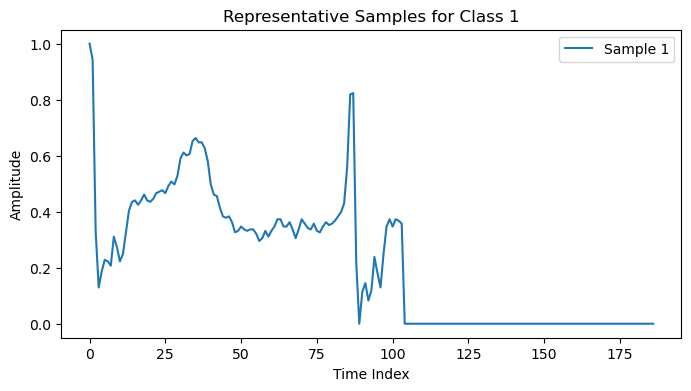

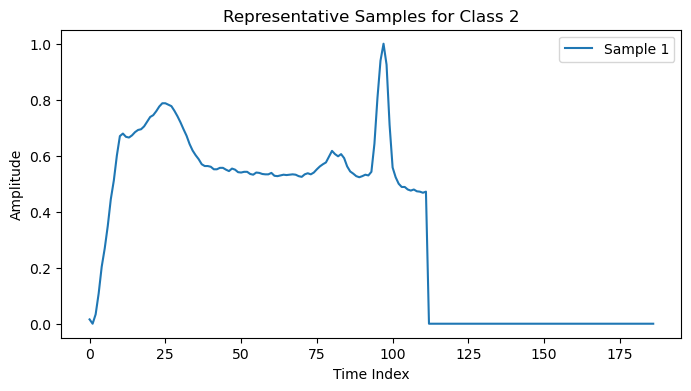

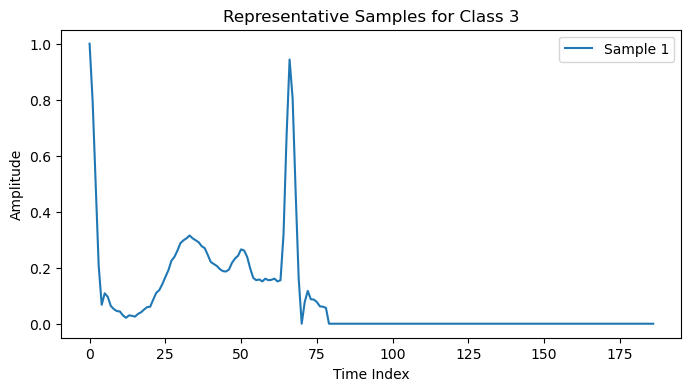

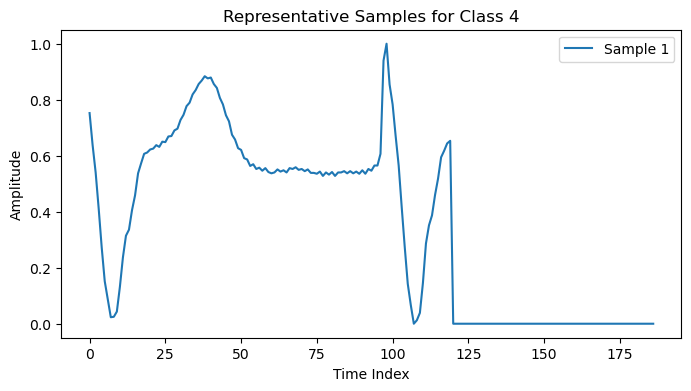

In [22]:
plot_unique_class_samples(X_train,y_train,num_samples=1,
                          xlabel="Time Index",
                          ylabel="Amplitude",
                          figsize=(8,4))

**Data Preprocessing**

In [23]:
import seaborn as sns
import numpy as np
from tqdm.auto import tqdm

from utils.data import sample

c:\Users\William\miniconda3\envs\neural_networks\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [24]:
X_train_preprocessed = np.copy(X_train)

-- Denoising using a Low-Pass Filter  
  
  Reason: Removes muscle artifact and smoothing.

In [25]:
from utils.preprocessing import apply_low_pass_filter

In [26]:
for i in tqdm(range(X_train.shape[0]), desc="Applying Low Pass Filter", leave=False):

    X_sample = X_train[i]

    X_train_preprocessed[i] = apply_low_pass_filter(sample=X_sample,
                          sampling_frequency=125,
                          cutoff_frequency=25)
    

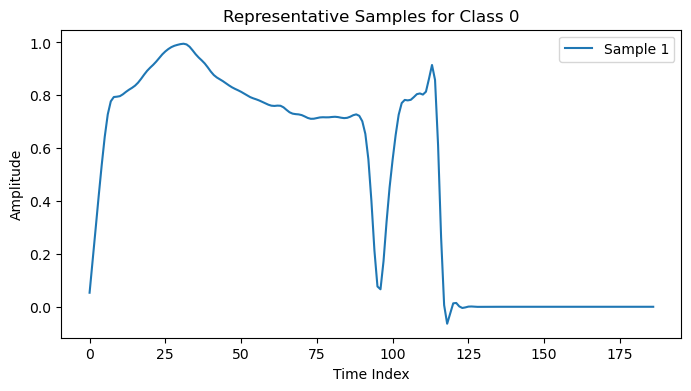

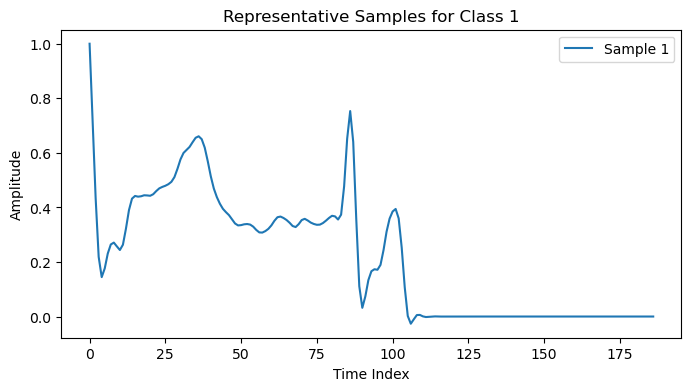

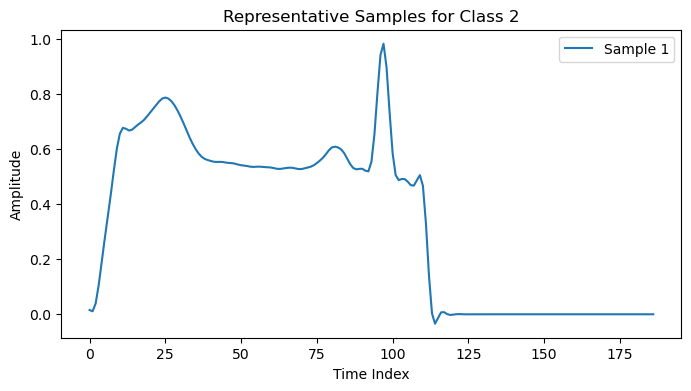

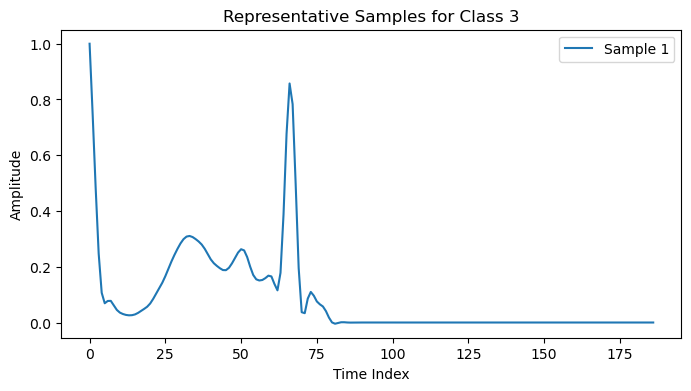

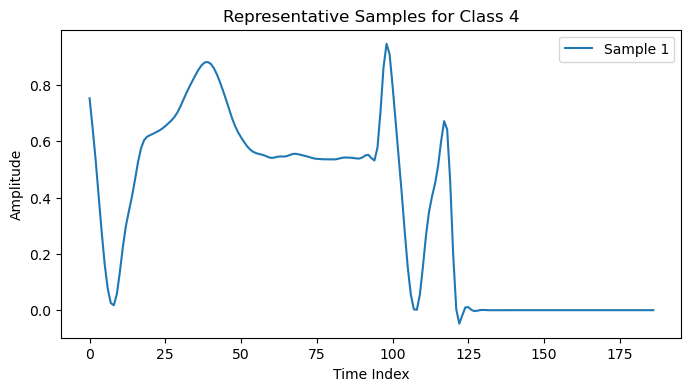

In [27]:
plot_unique_class_samples(X_train_preprocessed,y_train,num_samples=1,
                          xlabel="Time Index",
                          ylabel="Amplitude",
                          figsize=(8,4))

-- Detecting R-Peaks

In [28]:
from utils.preprocessing import get_r_peak_locations

In [29]:
# We just need a small sample because it will result in a mean close enough to the actual mean
X_train_sample = sample(X_train, sample_size_fraction= 0.01, random_state= 42)

print(f"Sampling {len(X_train_sample)} of {len(X_train)} samples")
print("--------------------------------------------")

r_peak_indices = get_r_peak_locations(X=X_train_sample, sampling_rate=125)

print(f"Mean R_Peak Index: {np.round(np.mean(r_peak_indices).item())}")

Sampling 700 of 70043 samples
--------------------------------------------


Mean R_Peak Index: 41.0


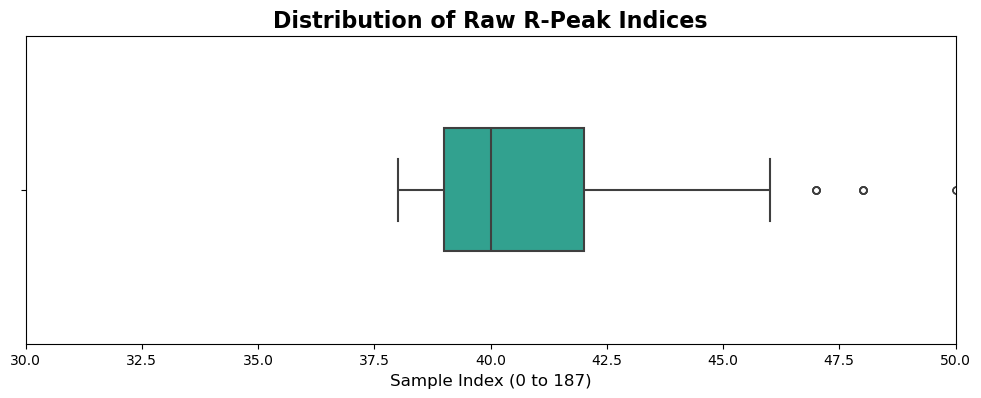

In [30]:
LOWER_LIMIT = 30
UPPER_LIMIT = 50 

plt.figure(figsize=(12, 4)) 

sns.boxplot(
    x=r_peak_indices, 
    color="#1fb49b", 
    width=0.4,        
    linewidth=1.5,     
    fliersize=5        
)

plt.xlim(LOWER_LIMIT, UPPER_LIMIT)

plt.title('Distribution of Raw R-Peak Indices', fontsize=16, fontweight='bold')
plt.xlabel('Sample Index (0 to 187)', fontsize=12)

plt.show()

It looks like the raw data is biased to have a peak around index 41  

However for this experiment we will be **shifing the R-peaks to Index 94 (187 / 2)**
  
Reason:  
  1) The primary reason for shifting the R-peaks from the observed raw mean of $\approx 41$ to the symmetrical center of Index 94 is to achieve optimal temporal symmetry for deep learning model stability and feature extraction.

  2) Maximizing Informative Features:   
    Initially we had 41 sequence samples consisting of P,Q waves (Before R). and 147 sequence samples consisting of the S,T waves (After R) and padded 0s. As you can see, the model has less time steps(for RNNs) / less samples to learn about P,Q waves (41 time steps).  

    By shifting the R to 94, we have more balanced feature set (94 samples before and 93 samples after), and so the model has more context (time steps / samples) to learn the pattern of both the P Q and S, T waves effectively, leading to a faster convergence and higher accuracy 

 

In [31]:
pd.DataFrame(X_train_preprocessed).head()

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
0,0.053188,0.173055,0.295903,0.418447,0.535885,0.643089,0.727962,0.777340,0.793658,0.794847,...,1.911676e-15,2.283795e-15,2.770824e-16,-6.957099e-16,-3.898904e-16,8.397984e-17,1.737608e-16,4.293053e-17,-4.378094e-17,-3.359771e-17
1,0.974269,0.809352,0.591354,0.341305,0.133386,0.019637,-0.005890,0.014844,0.041115,0.053894,...,-2.831183e-04,-1.418811e-04,4.120970e-05,6.769272e-05,1.370575e-05,-1.832040e-05,-1.254528e-05,1.257255e-06,4.985788e-06,1.641460e-06
2,0.752307,0.647139,0.532748,0.406215,0.276762,0.161867,0.075619,0.025257,0.017428,0.057377,...,2.118793e-14,-4.678648e-16,-7.727148e-15,-3.070262e-15,1.460592e-15,1.703093e-15,1.941882e-16,-5.240220e-16,-2.885138e-16,6.541595e-17
3,0.977657,0.817944,0.624566,0.436062,0.314484,0.264657,0.243016,0.216798,0.183687,0.151388,...,1.057829e-16,7.803942e-17,-4.912908e-18,-2.979666e-17,-1.073424e-17,6.095026e-18,6.368390e-18,5.009857e-19,-2.053781e-18,-1.038323e-18
4,0.015463,0.010905,0.039149,0.105595,0.190653,0.274717,0.354346,0.436237,0.522470,0.602323,...,-2.067209e-16,4.628915e-17,9.286676e-17,2.244448e-17,-2.360818e-17,-1.786625e-17,9.080638e-19,6.730853e-18,2.496497e-18,-1.346790e-18


-- R-Peak Alignment and Centering

In [32]:
from utils.preprocessing import linear_alignment_of_r_peak

In [33]:
for i in tqdm(range(X_train_preprocessed.shape[0]), leave=False, desc="Performing Linear Alignment"):

    X_sample = X_train_preprocessed[i]

    X_train_preprocessed[i] = linear_alignment_of_r_peak(sample=X_sample,
                                      sampling_rate=125,
                                      target_index=94,
                                      method="pantompkins")

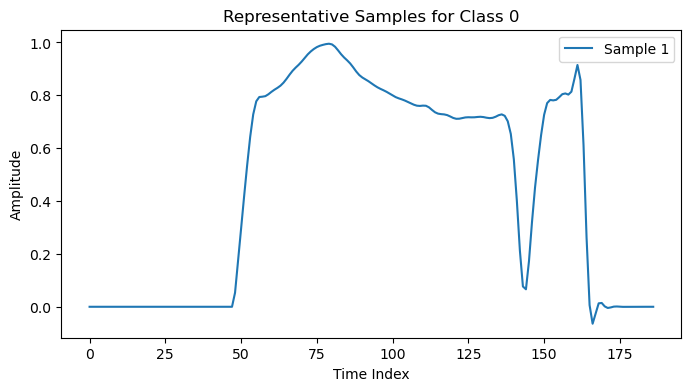

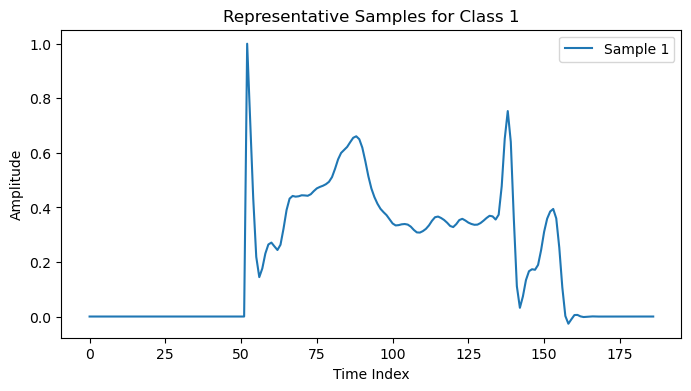

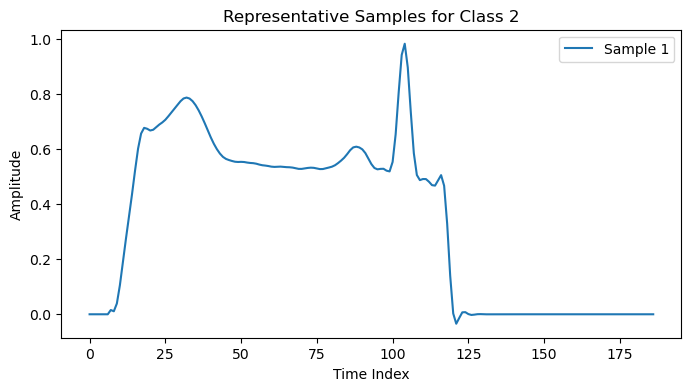

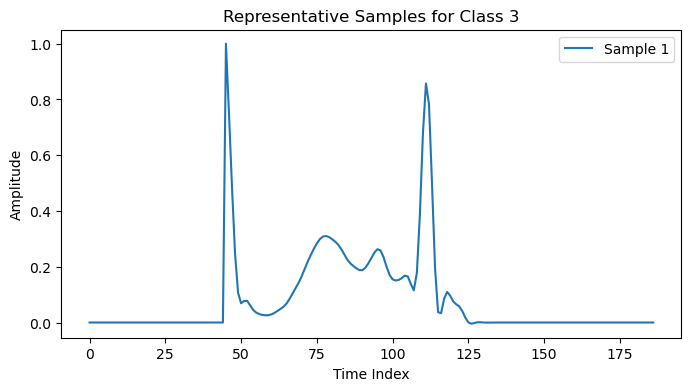

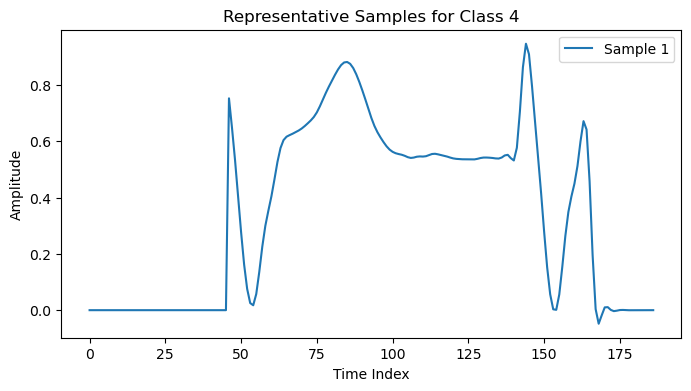

In [34]:
plot_unique_class_samples(X_train_preprocessed,y_train,num_samples=1,
                          xlabel="Time Index",
                          ylabel="Amplitude",
                          figsize=(8,4))

-- Normalizng Z-Score

This process ensures that every single heartbeat is presented to the neural network with a consistent, standard amplitude range ($\text{std} \approx 1$), forcing the network to focus on the morphology and timing, not the absolute amplitude

In [35]:
from utils.preprocessing import z_score_normalization

In [36]:
X_train_preprocessed = z_score_normalization(X_train_preprocessed)

In [37]:
pd.DataFrame(X_train_preprocessed).head()

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
0,-1.182145,-1.182145,-1.182145,-1.182145,-1.182145,-1.182145,-1.182145,-1.182145,-1.182145,-1.182145,...,-1.182677,-1.182107,-1.181940,-1.182072,-1.182187,-1.182188,-1.182148,-1.182131,-1.182138,-1.182147
1,-0.734296,-0.734296,-0.734296,-0.734296,-0.734296,-0.734296,-0.734296,-0.734296,-0.734296,-0.734296,...,0.604808,0.599605,0.694176,1.392226,2.833862,4.442852,5.301801,4.877568,3.390452,1.575262
2,-1.131289,-1.131289,-1.131289,-1.131289,-1.131289,-1.131289,-1.131289,-1.131289,-1.131289,-1.131289,...,-1.130708,-1.131991,-1.131789,-1.131249,-1.131094,-1.131221,-1.131330,-1.131330,-1.131291,-1.131275
3,-0.634064,-0.634064,-0.634064,-0.634064,-0.634064,-0.634064,-0.634064,-0.634064,-0.634064,-0.634064,...,-0.634443,-0.633823,-0.633828,-0.634051,-0.634142,-0.634101,-0.634052,-0.634045,-0.634060,-0.634069
4,-1.126108,-1.126108,-1.126108,-1.126108,-1.126108,-1.126108,-1.126108,-1.075028,-1.090085,-0.996788,...,-1.126108,-1.126108,-1.126108,-1.126108,-1.126108,-1.126108,-1.126108,-1.126108,-1.126108,-1.126108


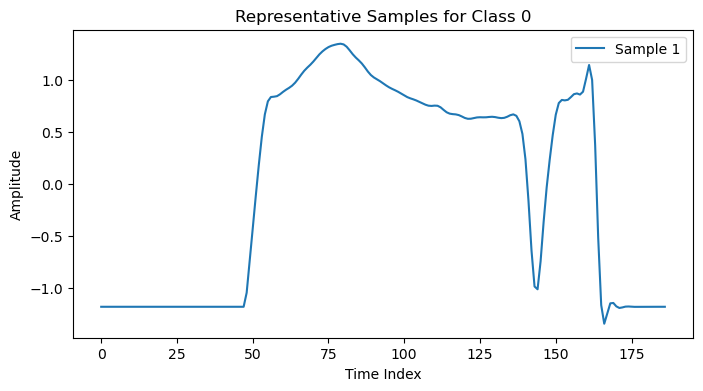

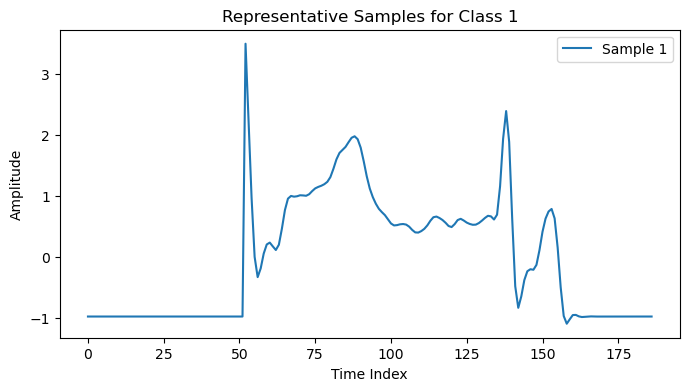

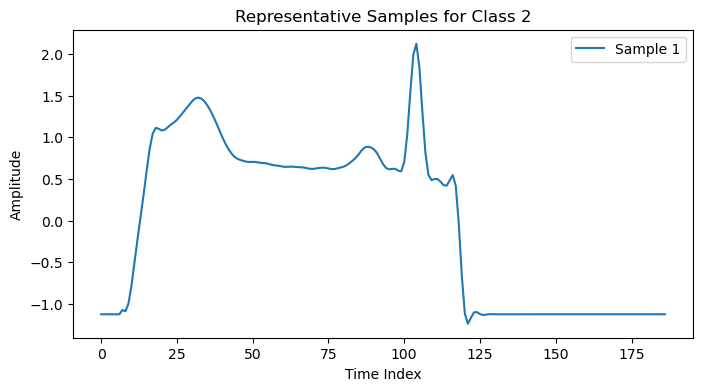

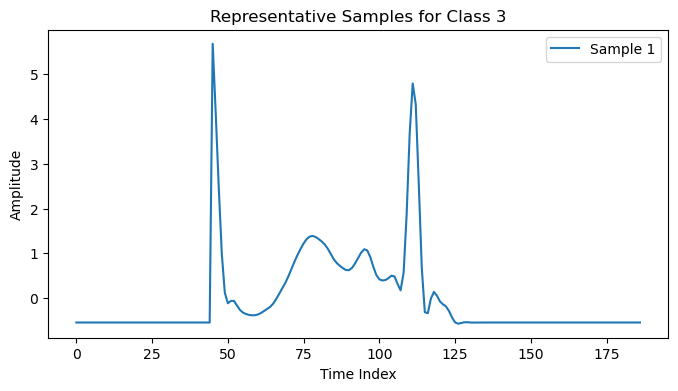

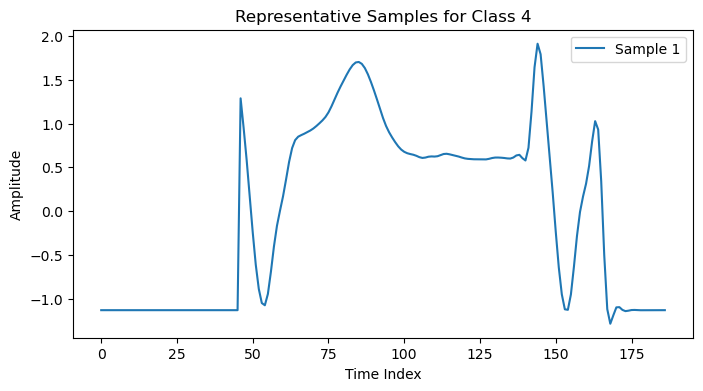

In [38]:
plot_unique_class_samples(X_train_preprocessed,y_train,num_samples=1,
                          xlabel="Time Index",
                          ylabel="Amplitude",
                          figsize=(8,4))

**Class Imbalance Analysis and Weight Calculation**  
  
We saw how the classes were imbalanced  
Hence for the training we will calculate class weights for each label.  
  
We will make use of a Random Weighted Sampler and use it in our dataloaders  
  
We used the inverse frequency of each class to compute the weights. Rarers classes would hence have higher weightage and would be sampled more often

In [39]:
import torch
from utils.data import calculate_class_weights

In [40]:
labels, class_weights = calculate_class_weights(y_train)

print("------------The Class Weights are as follows ----------\n")
for (label, weight) in zip(labels, class_weights):
    print(f"Class {label}: {weight}")

------------The Class Weights are as follows ----------

Class 0: 1.724821912137572e-05
Class 1: 0.0005624296962879641
Class 2: 0.00021598272138228941
Class 3: 0.001949317738791423
Class 4: 0.00019436345966958212


**Creating our Final Train, Val and Test DataFrames**

In [41]:
from utils.preprocessing import Preprocessing

In [42]:
preprocesser = Preprocessing(
    sample_freq= 125,
    cutoff_freq= 25,
    target_r_peak_index= 94,
    method="pantompkins"
)

# We've already Preprocessed the Train Set

# Preprocess Val Set
print("---------------Preprocessing Validation Data-------------")
X_val_preprocessed = preprocesser.transform(X_val)

print("\n--------------------------\n")


# Preprocess Test Set
print("---------------Preprocessing Test Data-------------------")
X_test_preprocessed = preprocesser.transform(X_test)

---------------Preprocessing Validation Data-------------
Applying Low-Pass Filter ...


Perforing R-Peak Realignment ... 


Performing Z-Score Normalization for Each Sample ...
Completed Preprocessing

--------------------------

---------------Preprocessing Test Data-------------------
Applying Low-Pass Filter ...


Perforing R-Peak Realignment ... 


Performing Z-Score Normalization for Each Sample ...
Completed Preprocessing


In [43]:
# Saving Preprocessed Data 
np.savez_compressed(
    "data/ecg_preprocessed.npz",
    X_train= X_train_preprocessed,
    y_train = y_train,
    X_val = X_val_preprocessed,
    y_val = y_val,
    X_test = X_test_preprocessed,
    y_test = y_test,
    sample_freq=125,
    cutoff_freq=25,
    target_r_peak_index=94,
    class_weights=class_weights
)

**TRAINING MODELS**

In [1]:
import pandas as pd
import numpy as np
import torch 
from torch import nn
from torch.utils.data import WeightedRandomSampler

In [9]:
# load pre processed data
data_path = "data/ecg_preprocessed.npz"
data = np.load(data_path)

X_train = data["X_train"]
y_train = data["y_train"]

X_val = data["X_val"]
y_val = data["y_val"]

X_test = data["X_test"]
y_test = data["y_test"]

class_weights = data["class_weights"]

# assign the weights to all of y_train
train_sample_weights = np.array(class_weights)[y_train]

train_sample_weights = torch.from_numpy(train_sample_weights).float()

weighted_sampler = WeightedRandomSampler(
    weights= train_sample_weights,
    num_samples= len(train_sample_weights),
    replacement=True,
)

NUM_CLASSES = len(class_weights)

**RNNS**: biLSTM

In [3]:
from utils.torch_classes import ECG_Dataset

-- Creating our Datasets

In [4]:
# Creating Datasets
train_dataset = ECG_Dataset(X=X_train, y=y_train)
val_dataset = ECG_Dataset(X=X_val, y=y_val)
test_dataset = ECG_Dataset(X=X_test, y=y_test)

-- HYPERPARAM Tuning

In [5]:
from torch import nn
from torch.utils.data import DataLoader
from torchmetrics import F1Score, AUROC, Precision, Recall

from utils.rnn_models import ECG_LSTM_Classifier
from utils.rnn_models import ECG_GRU_Classifier

from utils.torch_classes import EarlyStopping
from utils.train import train_and_eval_model, val_loop
from utils.logging import log_to_json, log_to_csv

import numpy as np
import random
import time

c:\Users\William\miniconda3\envs\neural_networks\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
from sklearn.model_selection import ParameterSampler

EXPERIMENTS = 60

param_grid = {
    "model": ["LSTM", "GRU"],
    "bidirectional": [True, False],
    "optimizer": ["Adam", "AdamW", "SGD"],
    "momentum": np.linspace(0.9,0.999,3).tolist(),
    "batch_size": [32,64,128],
    "hidden_size": [32,64,128,256],
    "num_layers": [1,2,3],
    "dropout": [0.1,0.2,0.3,0.5],
    "weight_decay": np.logspace(-5,-2,num=5).tolist(),
    "learning_rate": np.logspace(-4,-2,num=10).tolist(),
}

configs = list(ParameterSampler(
    param_grid, 
    n_iter=EXPERIMENTS, 
    random_state=42))

In [50]:
# Print 2 configs to visualise what they look like
configs[:1]

[{'weight_decay': 0.0017782794100389228,
  'optimizer': 'AdamW',
  'num_layers': 1,
  'momentum': 0.9495,
  'model': 'GRU',
  'learning_rate': 0.0001668100537200059,
  'hidden_size': 64,
  'dropout': 0.5,
  'bidirectional': True,
  'batch_size': 64}]

In [10]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
torch.backends.cudnn.deterministic = True

LOG_FOLDER = "random_search_results"
EPOCHS = 15

device = "cuda" if torch.cuda.is_available() else "cpu"

results_summary_json = []
results_summary_csv = []

val_precision_metric = Precision(task="multiclass", num_classes=NUM_CLASSES, average="macro").to(device)
val_recall_metric = Recall(task="multiclass", num_classes=NUM_CLASSES, average="macro").to(device)
val_f1_metric = F1Score(task="multiclass", num_classes=NUM_CLASSES, average="macro").to(device)
val_auc_metric = AUROC(task="multiclass", num_classes=NUM_CLASSES, average="macro").to(device)

for i, params in enumerate(configs):

  
    try: 
        # RESET METRICS
        val_precision_metric.reset()
        val_recall_metric.reset()
        val_f1_metric.reset()
        val_auc_metric.reset()

        print(f"-------------- Experiment {i + 1} ----------------")

        BATCH_SIZE = params['batch_size']
        OPTIM = params['optimizer']

        INPUT_SIZE = 1
        HIDDEN_SIZE = params["hidden_size"]
        NUM_LAYERS = params["num_layers"]
        DROPOUT = params["dropout"]
        BIDIRECTIONAL = params["bidirectional"]

        MOMENTUM = params["momentum"]
        LEARNING_RATE = params["learning_rate"]
        WEIGHT_DECAY = params["weight_decay"]

        MODEL = params['model']

        print(f"Model: {'Bi' if BIDIRECTIONAL else ''}{MODEL}")

# ----------------------------------------------------
        # We need to recreate the data loaders 
        train_dataloader = DataLoader(
            dataset=train_dataset,
            batch_size=BATCH_SIZE,
            sampler= weighted_sampler, # this is the Random Weighted Sampler we had created earlier 
            shuffle= False # we dont need to shuffle because we are using the sampler
        )

        val_dataloader = DataLoader(
            dataset=val_dataset,
            batch_size=BATCH_SIZE,
            shuffle=False
        )

        test_dataloader = DataLoader(
            dataset= test_dataset,
            batch_size=BATCH_SIZE,
            shuffle=False
        )

# ----------------------------------------------------
        # Create the Model 
        if MODEL == "LSTM":
            model = ECG_LSTM_Classifier(
                input_size=INPUT_SIZE,
                hidden_size=HIDDEN_SIZE,
                num_layers=NUM_LAYERS,
                num_classes=NUM_CLASSES,
                dropout=DROPOUT,
                bidirectional=BIDIRECTIONAL
            )

        elif MODEL == "GRU":
            model = ECG_GRU_Classifier(
                input_size=INPUT_SIZE,
                hidden_size=HIDDEN_SIZE,
                num_layers=NUM_LAYERS,
                num_classes=NUM_CLASSES,
                dropout=DROPOUT,
                bidirectional=BIDIRECTIONAL
            )
        model.to(device)
# ----------------------------------------------------
        # Create the optimiers 
        if OPTIM == "Adam":
            optim = torch.optim.Adam(params=model.parameters(),
                                    lr=LEARNING_RATE,
                                    weight_decay=WEIGHT_DECAY)

        elif OPTIM == "AdamW":
            optim = torch.optim.AdamW(params=model.parameters(),
                                    lr=LEARNING_RATE,
                                    weight_decay=WEIGHT_DECAY)
            
        elif OPTIM == "SGD":
            optim = torch.optim.SGD(params=model.parameters(),
                                    lr=LEARNING_RATE,
                                    momentum=MOMENTUM,
                                    weight_decay=WEIGHT_DECAY)

        else: 
            raise ValueError(f"Unknown optimizer: {OPTIM}")
# ----------------------------------------------------

        # Create Loss function
        loss_func = nn.CrossEntropyLoss()

        # Create Early Stopper
        early_stopper = EarlyStopping(
                patience=5, 
                delta=0,
                checkpoint_path=f"{LOG_FOLDER}/checkpoints/experiment_{i+1}.pt",
                verbose=False)

# ----------------------------------------------------
        start = time.time()
        results = train_and_eval_model(
            model=model, 
            loss_fn=loss_func,
            optimizer=optim,
            device=device,

            train_dataloader=train_dataloader,
            val_dataloader=val_dataloader,
            
            epochs=EPOCHS, # small epoch number during this phase
            early_stopper= early_stopper,

            verbose=False,
            debug=False
        )
        end = time.time()

        epochs_run = len(results["train_loss"])

        total_time = (end-start)
        time_per_epoch = total_time/epochs_run if epochs_run > 0 else 0 # (i+1) is the current epoch

# ----------------------------------------------------
        model.load_state_dict(torch.load(early_stopper.checkpoint_path, map_location=device)["model_state_dict"])
        best_val_data = val_loop(model=model, 
                                 val_dataloader=val_dataloader,
                                 loss_fn=loss_func, 
                                 device=device)
        
        best_val_pred = torch.cat(best_val_data["y_pred"])
        best_val_true = torch.cat(best_val_data["y_true"])

        # Calculate Precision
        best_val_precision = val_precision_metric(best_val_pred.to(device), best_val_true.to(device)).item()
        best_val_recall = val_recall_metric(best_val_pred.to(device), best_val_true.to(device)).item()

        # Calculate Recall

        # Calculate the F1 score 
        best_val_f1 = val_f1_metric(best_val_pred.to(device),best_val_true.to(device)).item()
        
        # Calculate the AUC
        best_val_auc = val_auc_metric(best_val_pred.to(device),best_val_true.to(device)).item()

# ----------------------------------------------------
        # Update Results Summary
        results_summary_csv.append({
            "experiment": i+1,
            **params,
            "epochs run": epochs_run,
            "total epochs": EPOCHS,
            "final_train_loss": results["train_loss"][-1],
            "final_val_loss": results["val_loss"][-1],
            "min_val_loss": early_stopper.val_loss_min,
            "best_val_precision": best_val_precision,
            "best_val_recall": best_val_recall,
            "best_val_f1": best_val_f1,
            "best_val_auc": best_val_auc,
            "total_time": total_time,
            "time_per_epoch": time_per_epoch
        })


        results_summary_json.append({
            "experiment": i + 1,
            "params": params,
            "train_loss": results['train_loss'],
            "val_loss": results['val_loss']
        }) 

        # Lets log the results
        log_to_csv(filepath="random_search_results/results.csv",
            content=results_summary_csv)

        log_to_json(filepath="random_search_results/results.json",
            content=results_summary_json)
        
        print(f"Epochs Run: {epochs_run} / {EPOCHS} ({early_stopper.early_stop})")
        print(f"Total Time: {total_time:.3f} s")
        print(f"Average Time Per Epoch: {time_per_epoch:.3f} s")
        print(f"Min Val Loss: {early_stopper.val_loss_min:.3f} | Best F1 Score: {best_val_f1:.3f}| Best AUC Score: {best_val_auc:.3f}")

        print("\n")

    except Exception as e:
        print(f"Experiment {i + 1} Failed ! : {e}")

print("---------------- All Experiments Completed --------------")

-------------- Experiment 1 ----------------
Model: BiGRU


KeyboardInterrupt: 